# Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn import metrics
import pickle

# Carregando os dados

In [2]:
data = pd.read_csv('Teste Técnico - DS\\Teste Te╠ücnico - DS\\full_devices.csv', encoding='latin-1')

In [3]:
data

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


# Análise Exploratória dos Dados (EDA) e Feature Engineering

Temos 12 colunas, sendo 10 numéricas e 2 categóricas e de data.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


Não temos dados faltantes

In [5]:
data.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [6]:
data.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

Apenas 0.085% dos dados são falhas, então os dados são extremamente desbalanceados

In [9]:
data.failure.value_counts()[1]/data.failure.value_counts().sum()

0.000851446656063746

Temos 1169 dispositivos diferentes.\
A frequência em que eles aparecem nos dados varia.

In [10]:
data.device.value_counts()

Z1F0QLC1    304
S1F0KYCR    304
S1F0E9EP    304
S1F0EGMT    304
S1F0FGBQ    304
           ... 
W1F1CHZK      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5ÿ      1
Name: device, Length: 1169, dtype: int64

Temos dados dos atributos de 304 dias

In [11]:
data.date.value_counts()

2015-01-01    1163
2015-01-02    1163
2015-01-03    1163
2015-01-04    1162
2015-01-05    1161
              ... 
2015-10-27      31
2015-10-29      31
2015-10-30      31
2015-10-31      31
2015-11-02      31
Name: date, Length: 304, dtype: int64

Vamos converter a coluna com as datas para a formato datetime.

In [12]:
data['date'] = pd.to_datetime(data['date'])

Extraindo informações de tempo.

In [35]:
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
data['day'] = data.date.dt.day
data['weekday'] = data.date.dt.weekday
data['device_active_days']=data.date-data.date[0]

Temos dispositivos ativos 105 dias em média.

In [38]:
data['device_active_days'].describe()

count                         124494
mean     105 days 05:20:49.737336740
std       78 days 09:53:22.062814279
min                  0 days 00:00:00
25%                 39 days 00:00:00
50%                 85 days 00:00:00
75%                167 days 00:00:00
max                305 days 00:00:00
Name: device_active_days, dtype: object

In [25]:
attrib_columns = data.columns.tolist()[3:12]

A quantidade de dispositivos foi diminuindo com o passar dos meses, indicando a desativação deles.

In [51]:
data.groupby('month').agg({'device':lambda x: x.nunique()})

,device
month,
1,1164
2,726
3,685
4,491
5,424
6,353
7,346
8,334
9,184


Criando coluna para indicar a última data de determinado dispositivo.

In [53]:
data['device_last_date'] = data.device.map(data.groupby('device').agg({'date':max}).date.to_dict())

Apenas 4 dispositivos retornaram ao uso após falha. Então todos os outros dispositivos que falharam tiveram seu uso descontinuado.

In [64]:
fail_return = data[(data['failure']==1)&(data['date']<data['device_last_date'])]
fail_return

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,year,day,weekday,device_active_days,device_last_date
77958,2015-05-05,S1F136J0,1,131519808,0,0,25,16,343464,8,8,0,5,2015,5,1,124 days,2015-05-06
79590,2015-05-09,W1F0KCP2,1,176861128,10392,0,121,6,310699,0,0,0,5,2015,9,5,128 days,2015-05-11
79601,2015-05-09,W1F0M35B,1,141805096,0,0,1,7,267203,0,0,0,5,2015,9,5,128 days,2015-05-11
101999,2015-07-12,S1F0GPFZ,1,236544080,0,0,0,9,264594,0,0,0,7,2015,12,6,192 days,2015-07-24
104223,2015-07-18,W1F11ZG9,1,32671632,368,9,486,3,344433,0,0,1,7,2015,18,5,198 days,2015-08-17


Então, para os dispositivos que já falharam antes, vamos criar uma coluna para indicar que já houve falha.

In [79]:
data['failed_past'] = pd.Series(np.zeros(data.shape[0]))

In [85]:
for device in fail_return['device'].tolist():
    data.loc[data['device']==device,'failed_past'] = 1

Vamos fazer os gráficos das séries temporais de cada atributo para analisar seu comportamento

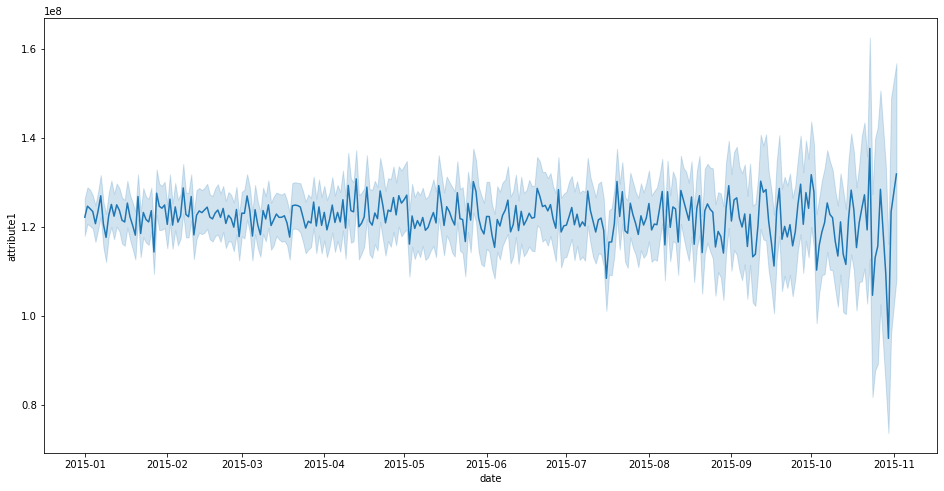

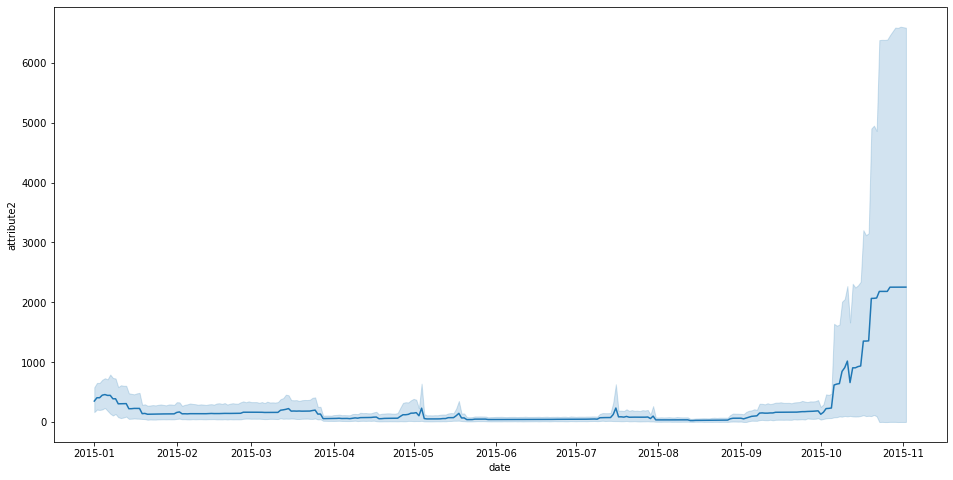

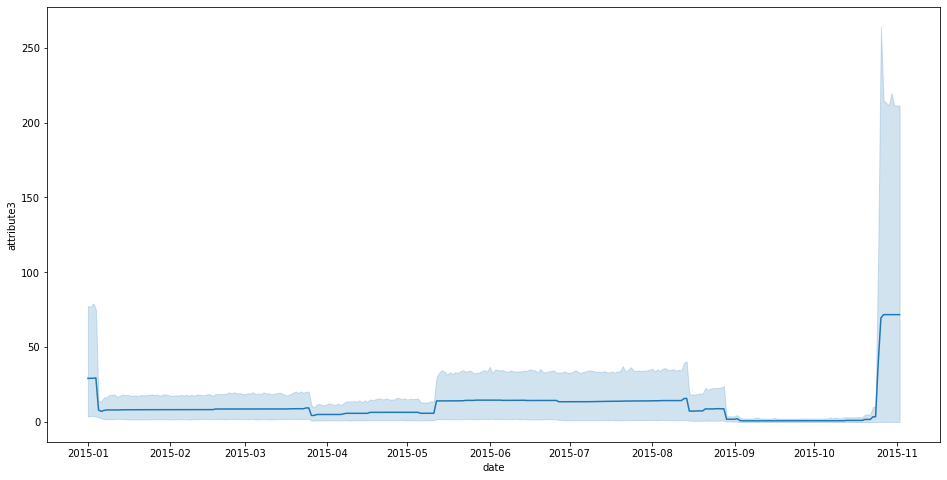

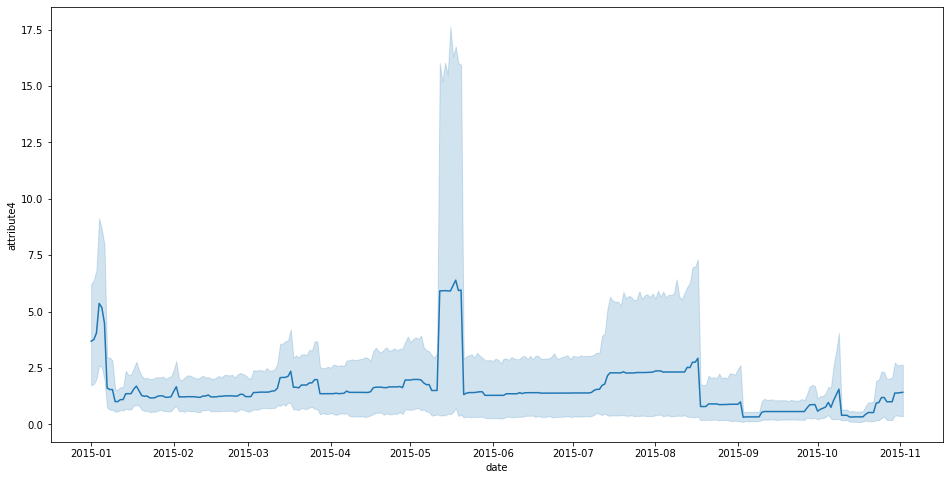

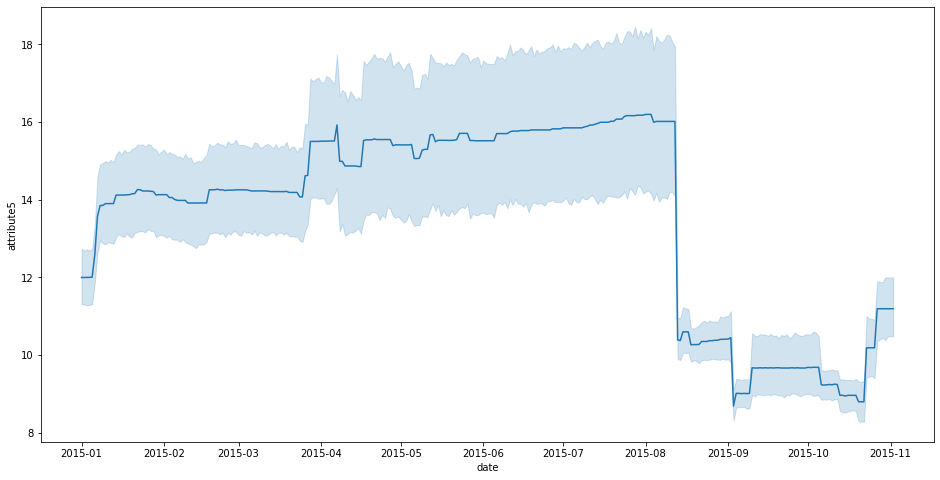

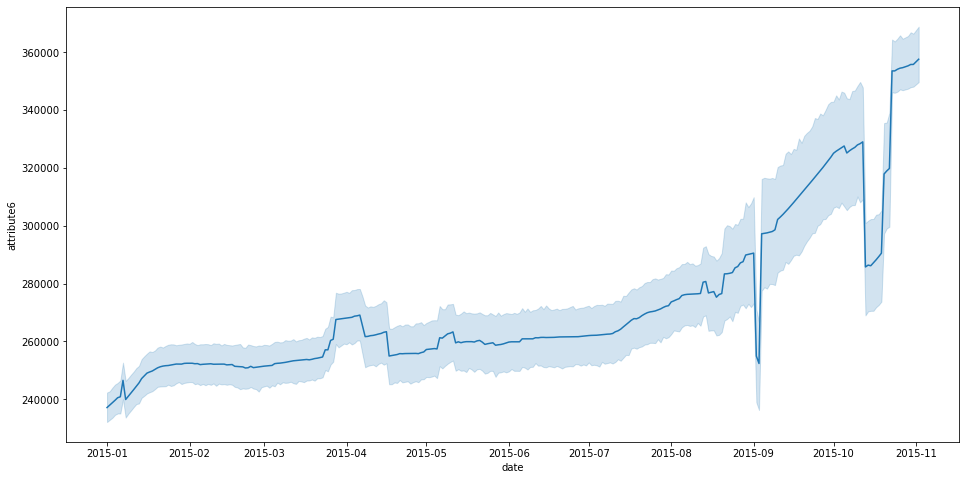

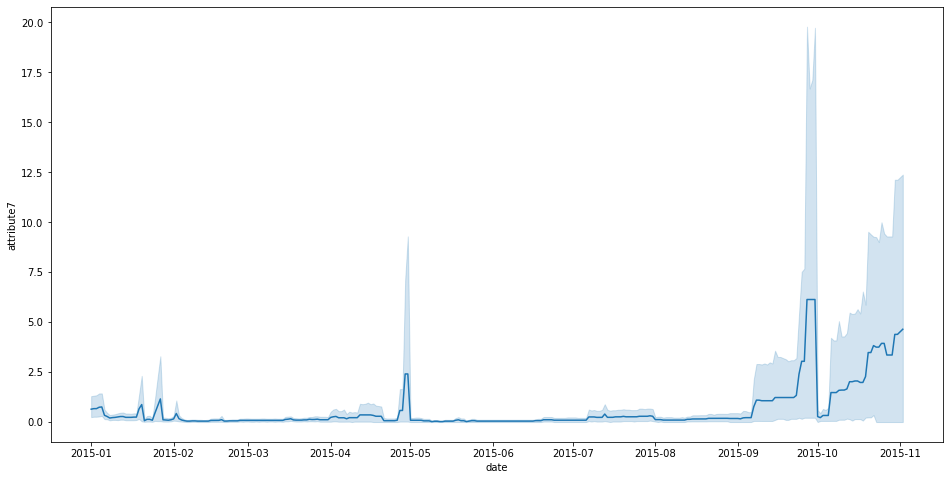

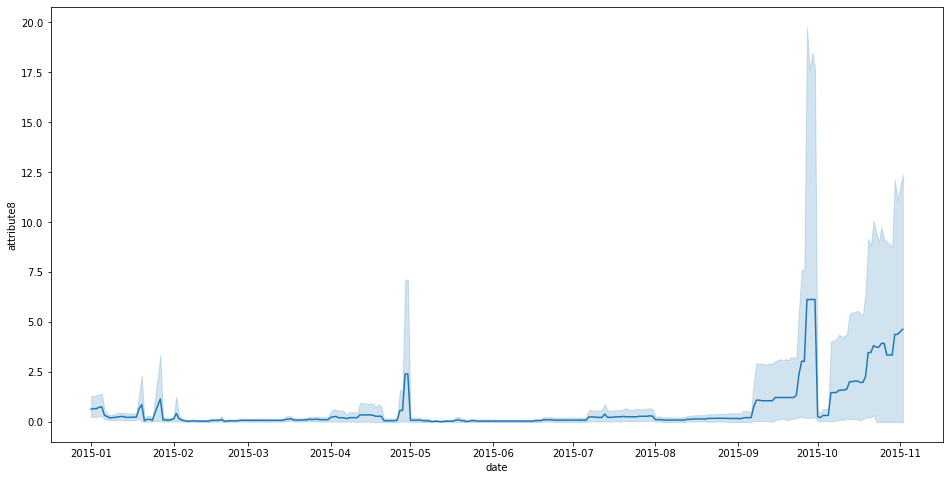

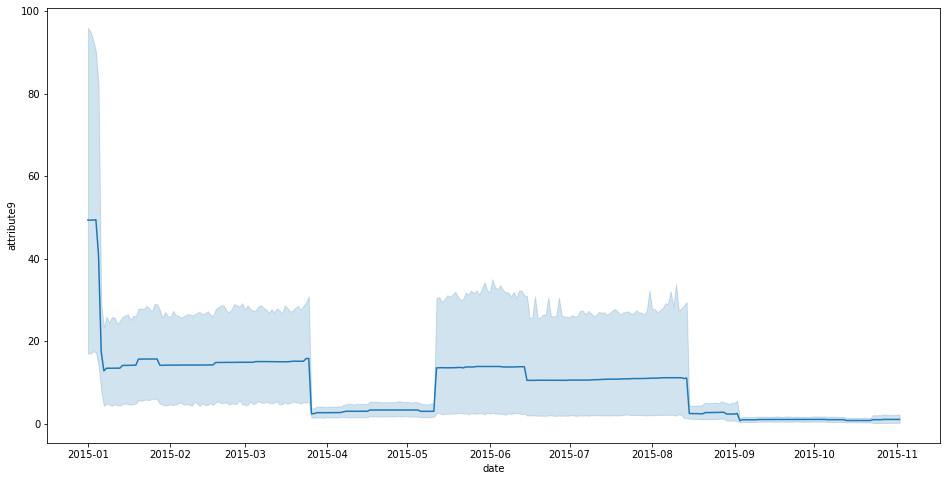

In [26]:
for attrib in attrib_columns  :  
    plt.figure(figsize=(12,8))
    sns.lineplot(x = data['date'], y=data[attrib])
    plt.title('Time Series - {}'.format(attrib))
    plt.show()

Os atributos 7 e 8 apresentam um gráfico idêntico, o que deve ser avaliado.\
 O atributo 6, por exemplo, parece ter uma tendência crescente, porém também houve uma queda drástica em certo período. \
 O atributo 1 parece um ruído branco, porém mais no fim da série sua variância aumenta.

Concluímos que os atributos 7 e 8 são idênticos.

In [32]:
(data['attribute7']==data['attribute8']).value_counts()

True    124494
dtype: int64

As falhas são mais comuns em Janeiro e Maio. Não houveram falhas em Setembro e Novembro.

In [27]:
data.groupby('month').sum()['failure']

month
1     24
2     14
3      9
4      9
5     21
6      6
7     16
8      4
9      0
10     3
11     0
Name: failure, dtype: int64

<AxesSubplot:xlabel='month', ylabel='count'>

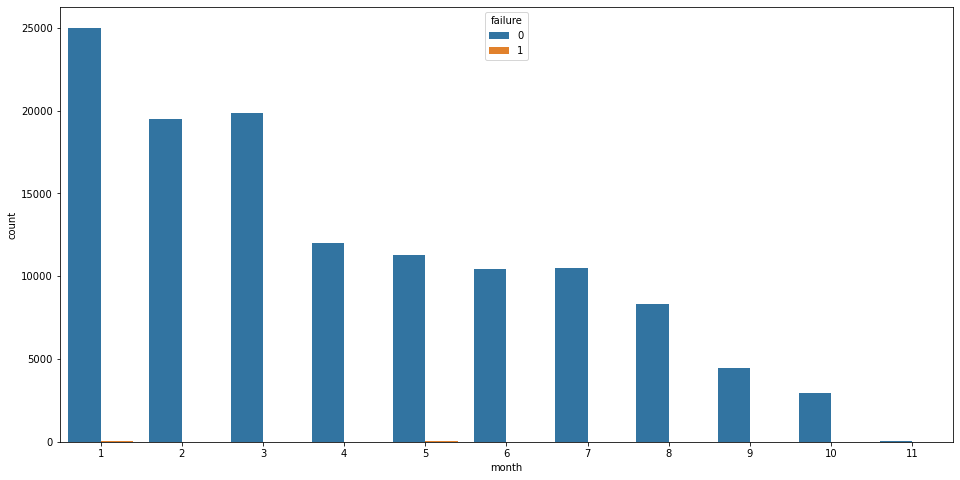

In [65]:
plt.figure(figsize=(16,8))
sns.countplot(x = data['month'], hue=data['failure'])

O dia da semana com mais falhas é Segunda-feira, seguido por Quinta-feira.

In [30]:
data.groupby('weekday').sum()['failure']

weekday
0    27
1    18
2    15
3    22
4    12
5     8
6     4
Name: failure, dtype: int64

<AxesSubplot:xlabel='weekday', ylabel='count'>

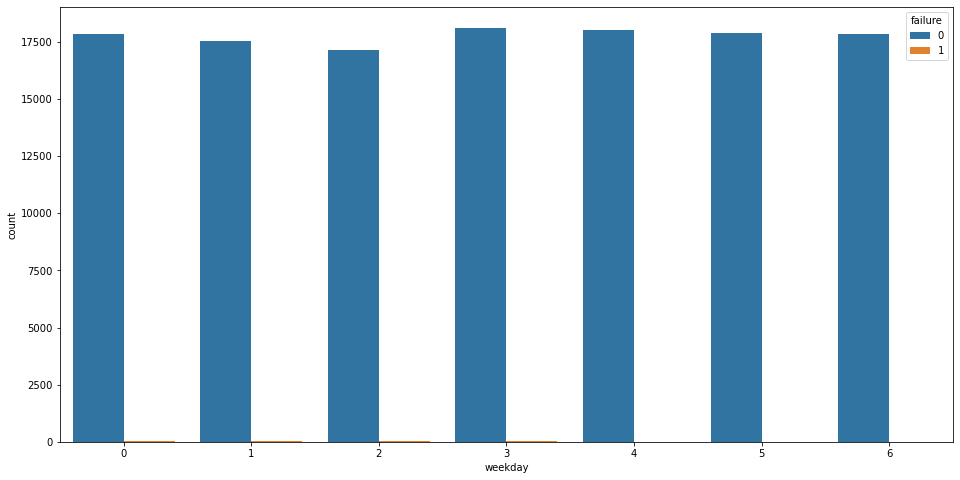

In [66]:
plt.figure(figsize=(16,8))
sns.countplot(x = data['weekday'], hue=data['failure'])

Vamos transformar os dias ativos do tipo datetime para inteiro.

In [ ]:
def str_to_num(str):
    return str.split(' ')[0]

In [89]:
data['device_active_days'] = data['device_active_days'].astype(str)

In [91]:
data['device_active_days'] = data['device_active_days'].apply(lambda x: x.split(' ')[0])

In [92]:
data['device_active_days']

0           0
1           0
2           0
3           0
4           0
         ... 
124489    305
124490    305
124491    305
124492    305
124493    305
Name: device_active_days, Length: 124494, dtype: object

In [93]:
data['device_active_days'] = data['device_active_days'].astype(int)

In [94]:
data['device_active_days']

0           0
1           0
2           0
3           0
4           0
         ... 
124489    305
124490    305
124491    305
124492    305
124493    305
Name: device_active_days, Length: 124494, dtype: int32

Vamos separar os dados em X e Y\
Vamos retirar o atributo 7 e manter o 8

In [95]:
data.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9', 'month', 'year', 'day', 'weekday', 'device_active_days',
       'device_last_date', 'failed_past'],
      dtype='object')

In [97]:
X = data.drop(columns=['date','device','failure','device_last_date', 'attribute7', 'month','year','day','weekday'])
X.columns

Index(['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5',
       'attribute6', 'attribute8', 'attribute9', 'device_active_days',
       'failed_past'],
      dtype='object')

In [98]:
y = data['failure']
y

0         0
1         0
2         0
3         0
4         0
         ..
124489    0
124490    0
124491    0
124492    0
124493    0
Name: failure, Length: 124494, dtype: int64

Usando a técnica SMOTEEN que mistura o oversampling e o undersampling para dados desbalanceados.

In [104]:
from imblearn.combine import SMOTEENN
resample = SMOTEENN(random_state=42)
X_res, Y_res = resample.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(Y_res))

Resampled dataset shape Counter({1: 93597, 0: 89120})


Vamos normalizar os dados usando o Standard Scaler

In [105]:
scaler = StandardScaler()
X_res_scaler= pd.DataFrame(scaler.fit_transform(X_res.values), columns=X_res.columns, index=X_res.index)

Dividindo os dados em treinamento e teste

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res_scaler, Y_res, test_size=0.20, random_state=42)

# Modelo

Foram pesquisados artigos sobre dados desbalanceados e modelos supervisionados e o mas comum encontrado foi o XGBoost, então ele será o foco neste projeto, porém, ainda assim é válido criar outros modelos, como o LightGBM, RandomForest, etc.

# Hyperparameter Tuning with Optuna

A métrica de validação usado é o AUC e visa maximizar o F1-Score.

In [109]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "scale_pos_weight": trial.suggest_float('scale_pos_weight',1,198),
        'eval_metric': 'auc'
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)


    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    f1_score = metrics.f1_score(y_test, pred_labels)
    return f1_score

In [112]:
study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )

[I 2023-02-15 09:37:39,703] A new study created in memory with name: no-name-71a675be-2cd9-4566-99c3-ab6a8cc9f509


Vamos rodar 100 trials, o que demora aproximadamente 5 minutos.

In [113]:
study.optimize(objective, n_trials=100)

[0]	validation-auc:0.73191
[1]	validation-auc:0.73889
[2]	validation-auc:0.74497
[3]	validation-auc:0.75017
[4]	validation-auc:0.75559
[5]	validation-auc:0.76188
[6]	validation-auc:0.76925
[7]	validation-auc:0.77704
[8]	validation-auc:0.78465
[9]	validation-auc:0.79077


[I 2023-02-15 09:37:59,454] Trial 0 finished with value: 0.6777385798281321 and parameters: {'booster': 'gblinear', 'lambda': 0.15560403602034104, 'alpha': 5.069631197416086e-06, 'subsample': 0.5559503424870118, 'colsample_bytree': 0.48300168101208957, 'scale_pos_weight': 153.126023688599}. Best is trial 0 with value: 0.6777385798281321.


[0]	validation-auc:0.90670
[1]	validation-auc:0.92948
[2]	validation-auc:0.93549
[3]	validation-auc:0.96082
[4]	validation-auc:0.96393
[5]	validation-auc:0.97321
[6]	validation-auc:0.97890
[7]	validation-auc:0.97778
[8]	validation-auc:0.97710
[9]	validation-auc:0.97604


[I 2023-02-15 09:38:00,788] Trial 1 finished with value: 0.6777385798281321 and parameters: {'booster': 'gbtree', 'lambda': 0.10919262906604688, 'alpha': 0.0006505539515563657, 'subsample': 0.7430116848467427, 'colsample_bytree': 0.28755633068083414, 'scale_pos_weight': 91.35455715392123, 'max_depth': 7, 'min_child_weight': 8, 'eta': 6.465553297842414e-06, 'gamma': 0.0007216424023299722, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6777385798281321.


[0]	validation-auc:0.86101
[1]	validation-auc:0.90673
[2]	validation-auc:0.92800
[3]	validation-auc:0.93595
[4]	validation-auc:0.93646
[5]	validation-auc:0.93647
[6]	validation-auc:0.93645
[7]	validation-auc:0.93637
[8]	validation-auc:0.93568
[9]	validation-auc:0.93515


[I 2023-02-15 09:38:01,285] Trial 2 finished with value: 0.6777385798281321 and parameters: {'booster': 'gblinear', 'lambda': 0.0006561642946657616, 'alpha': 0.7924124308499735, 'subsample': 0.5648180417424866, 'colsample_bytree': 0.5260753832820533, 'scale_pos_weight': 157.0632531501686}. Best is trial 0 with value: 0.6777385798281321.


[0]	validation-auc:0.97119
[1]	validation-auc:0.98444
[2]	validation-auc:0.98937
[3]	validation-auc:0.99241
[4]	validation-auc:0.99196
[5]	validation-auc:0.99239
[6]	validation-auc:0.99268
[7]	validation-auc:0.99309
[8]	validation-auc:0.99477
[9]	validation-auc:0.99536


[I 2023-02-15 09:38:03,483] Trial 3 finished with value: 0.958122221073312 and parameters: {'booster': 'dart', 'lambda': 0.00015801796509077733, 'alpha': 0.0036834496838751567, 'subsample': 0.2720076671443084, 'colsample_bytree': 0.7208080451652965, 'scale_pos_weight': 3.4191790234326103, 'max_depth': 7, 'min_child_weight': 2, 'eta': 1.0443412343142229e-05, 'gamma': 0.06866564707778074, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.059227134909231e-08, 'skip_drop': 2.1038015421211913e-06}. Best is trial 3 with value: 0.958122221073312.


[0]	validation-auc:0.74105
[1]	validation-auc:0.74685
[2]	validation-auc:0.75328
[3]	validation-auc:0.76011
[4]	validation-auc:0.76679
[5]	validation-auc:0.77331
[6]	validation-auc:0.77851
[7]	validation-auc:0.78310
[8]	validation-auc:0.78630
[9]	validation-auc:0.78888


[I 2023-02-15 09:38:04,150] Trial 4 finished with value: 0.6777385798281321 and parameters: {'booster': 'gblinear', 'lambda': 0.3461884845607272, 'alpha': 1.1204067893222089e-06, 'subsample': 0.6377024010066276, 'colsample_bytree': 0.5818642821412113, 'scale_pos_weight': 69.68720936571835}. Best is trial 3 with value: 0.958122221073312.


[0]	validation-auc:0.68084
[1]	validation-auc:0.82328
[2]	validation-auc:0.97073
[3]	validation-auc:0.96868
[4]	validation-auc:0.98416
[5]	validation-auc:0.98890
[6]	validation-auc:0.98945
[7]	validation-auc:0.98902
[8]	validation-auc:0.98821
[9]	validation-auc:0.99089


[I 2023-02-15 09:38:06,471] Trial 5 finished with value: 0.7112452772873118 and parameters: {'booster': 'dart', 'lambda': 0.005086275136379805, 'alpha': 4.035253584051864e-05, 'subsample': 0.36147871061260867, 'colsample_bytree': 0.38011874662369166, 'scale_pos_weight': 120.93374036177971, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.01115969227837535, 'gamma': 1.321492041674017e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.02930993128439939, 'skip_drop': 6.037980114251288e-07}. Best is trial 3 with value: 0.958122221073312.


[0]	validation-auc:0.74242
[1]	validation-auc:0.74504
[2]	validation-auc:0.74699
[3]	validation-auc:0.74925
[4]	validation-auc:0.75353


[I 2023-02-15 09:38:06,799] Trial 6 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84985
[1]	validation-auc:0.94913
[2]	validation-auc:0.98045
[3]	validation-auc:0.98005
[4]	validation-auc:0.98094
[5]	validation-auc:0.98342
[6]	validation-auc:0.98608
[7]	validation-auc:0.98882
[8]	validation-auc:0.98875
[9]	validation-auc:0.98829


[I 2023-02-15 09:38:08,782] Trial 7 finished with value: 0.6975774165316648 and parameters: {'booster': 'dart', 'lambda': 4.879719200410081e-08, 'alpha': 0.15584743200289597, 'subsample': 0.4292260757670729, 'colsample_bytree': 0.4925393220178528, 'scale_pos_weight': 80.24980395953303, 'max_depth': 7, 'min_child_weight': 6, 'eta': 2.77191554090601e-06, 'gamma': 1.3327537973844403e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2613286651450316, 'skip_drop': 0.7244896311879794}. Best is trial 3 with value: 0.958122221073312.


[0]	validation-auc:0.90340
[1]	validation-auc:0.95819
[2]	validation-auc:0.96094
[3]	validation-auc:0.96571
[4]	validation-auc:0.96659
[5]	validation-auc:0.96570


[I 2023-02-15 09:38:09,452] Trial 8 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87556
[1]	validation-auc:0.93338
[2]	validation-auc:0.96921
[3]	validation-auc:0.97581
[4]	validation-auc:0.97643
[5]	validation-auc:0.97862


[I 2023-02-15 09:38:10,966] Trial 9 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.89928
[4]	validation-auc:0.91535


[I 2023-02-15 09:38:11,766] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69845
[1]	validation-auc:0.83069
[2]	validation-auc:0.93319
[3]	validation-auc:0.95389
[4]	validation-auc:0.96913
[5]	validation-auc:0.96862


[I 2023-02-15 09:38:12,959] Trial 11 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.94520
[1]	validation-auc:0.94252
[2]	validation-auc:0.94368
[3]	validation-auc:0.96927
[4]	validation-auc:0.96979


[I 2023-02-15 09:38:14,465] Trial 12 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71242
[1]	validation-auc:0.83181
[2]	validation-auc:0.97972
[3]	validation-auc:0.97909
[4]	validation-auc:0.99076
[5]	validation-auc:0.99428
[6]	validation-auc:0.99515
[7]	validation-auc:0.99627
[8]	validation-auc:0.99650
[9]	validation-auc:0.99778


[I 2023-02-15 09:38:16,522] Trial 13 finished with value: 0.9272169134029806 and parameters: {'booster': 'dart', 'lambda': 0.015972100892563217, 'alpha': 0.0277970538431022, 'subsample': 0.2162137529742084, 'colsample_bytree': 0.3814251669872735, 'scale_pos_weight': 51.25543204168623, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.5591804484265271, 'gamma': 0.009227588044817953, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.7993735945220802e-05, 'skip_drop': 1.3897876394674935e-07}. Best is trial 3 with value: 0.958122221073312.


[0]	validation-auc:0.95628
[1]	validation-auc:0.98066
[2]	validation-auc:0.98240
[3]	validation-auc:0.98713
[4]	validation-auc:0.98736
[5]	validation-auc:0.98973
[6]	validation-auc:0.99104
[7]	validation-auc:0.99253
[8]	validation-auc:0.99430
[9]	validation-auc:0.99544


[I 2023-02-15 09:38:18,160] Trial 14 finished with value: 0.9662874438993843 and parameters: {'booster': 'dart', 'lambda': 0.02383250015463532, 'alpha': 0.02578919926085647, 'subsample': 0.21409960671622402, 'colsample_bytree': 0.6945321440812953, 'scale_pos_weight': 2.734533266677744, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.39473815289613223, 'gamma': 0.026063770799840666, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.1660113269292503e-06, 'skip_drop': 1.9146460065099147e-08}. Best is trial 14 with value: 0.9662874438993843.


[0]	validation-auc:0.95768
[1]	validation-auc:0.97794
[2]	validation-auc:0.97568
[3]	validation-auc:0.98028
[4]	validation-auc:0.97974


[I 2023-02-15 09:38:19,326] Trial 15 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.93589
[1]	validation-auc:0.97730
[2]	validation-auc:0.97738
[3]	validation-auc:0.98357
[4]	validation-auc:0.98525
[5]	validation-auc:0.98588
[6]	validation-auc:0.98568


[I 2023-02-15 09:38:20,290] Trial 16 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.94525
[1]	validation-auc:0.97863
[2]	validation-auc:0.98070
[3]	validation-auc:0.98596
[4]	validation-auc:0.98613
[5]	validation-auc:0.98816
[6]	validation-auc:0.98852
[7]	validation-auc:0.98987
[8]	validation-auc:0.99363
[9]	validation-auc:0.99523


[I 2023-02-15 09:38:21,987] Trial 17 finished with value: 0.9354347228813348 and parameters: {'booster': 'dart', 'lambda': 0.02876630766871789, 'alpha': 0.07124452008537653, 'subsample': 0.3334961282820166, 'colsample_bytree': 0.6390752797037348, 'scale_pos_weight': 28.337329567431567, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.5727628667768965, 'gamma': 0.0033427692262692193, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.6693004712811157e-08, 'skip_drop': 0.0001889930215587613}. Best is trial 14 with value: 0.9662874438993843.


[0]	validation-auc:0.96339
[1]	validation-auc:0.97413
[2]	validation-auc:0.97880
[3]	validation-auc:0.98057
[4]	validation-auc:0.97973
[5]	validation-auc:0.97986


[I 2023-02-15 09:38:23,023] Trial 18 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.96013
[2]	validation-auc:0.96097
[3]	validation-auc:0.95940
[4]	validation-auc:0.97224
[5]	validation-auc:0.97213


[I 2023-02-15 09:38:23,941] Trial 19 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.92486
[1]	validation-auc:0.95904
[2]	validation-auc:0.95757
[3]	validation-auc:0.95825
[4]	validation-auc:0.95925


[I 2023-02-15 09:38:24,706] Trial 20 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.95165
[1]	validation-auc:0.97915
[2]	validation-auc:0.98058
[3]	validation-auc:0.98527
[4]	validation-auc:0.98540
[5]	validation-auc:0.98759
[6]	validation-auc:0.98802
[7]	validation-auc:0.98935
[8]	validation-auc:0.99223
[9]	validation-auc:0.99421


[I 2023-02-15 09:38:26,260] Trial 21 finished with value: 0.9343313373253493 and parameters: {'booster': 'dart', 'lambda': 0.023802215487739246, 'alpha': 0.06171832097585801, 'subsample': 0.33652623032281115, 'colsample_bytree': 0.6365302975346456, 'scale_pos_weight': 19.815648949612665, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.47520503949385506, 'gamma': 0.0043350266621006136, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2736226333763896e-08, 'skip_drop': 0.0003341868209163564}. Best is trial 14 with value: 0.9662874438993843.


[0]	validation-auc:0.95237
[1]	validation-auc:0.95725
[2]	validation-auc:0.98441
[3]	validation-auc:0.98648
[4]	validation-auc:0.98801
[5]	validation-auc:0.99170
[6]	validation-auc:0.99430
[7]	validation-auc:0.99486
[8]	validation-auc:0.99597
[9]	validation-auc:0.99610


[I 2023-02-15 09:38:27,703] Trial 22 finished with value: 0.9574266792809839 and parameters: {'booster': 'dart', 'lambda': 0.04331649920618729, 'alpha': 0.014080498691843262, 'subsample': 0.300756498038813, 'colsample_bytree': 0.793251409290442, 'scale_pos_weight': 41.74491519543933, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9902953147761037, 'gamma': 0.0028207458159641946, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.205352907157005e-07, 'skip_drop': 0.00030600141864010926}. Best is trial 14 with value: 0.9662874438993843.


[0]	validation-auc:0.95922
[1]	validation-auc:0.98051
[2]	validation-auc:0.98854
[3]	validation-auc:0.99454
[4]	validation-auc:0.99321
[5]	validation-auc:0.99563
[6]	validation-auc:0.99741
[7]	validation-auc:0.99767
[8]	validation-auc:0.99829
[9]	validation-auc:0.99859


[I 2023-02-15 09:38:29,353] Trial 23 finished with value: 0.976659277611162 and parameters: {'booster': 'dart', 'lambda': 0.9580230370456807, 'alpha': 0.008893442677567568, 'subsample': 0.20915603350846237, 'colsample_bytree': 0.7953667019207958, 'scale_pos_weight': 48.13761828887612, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.9547602953025166, 'gamma': 0.04517452694861785, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.314263842760643e-07, 'skip_drop': 0.0012663410437119696}. Best is trial 23 with value: 0.976659277611162.


[0]	validation-auc:0.93829
[1]	validation-auc:0.94085
[2]	validation-auc:0.97749
[3]	validation-auc:0.98182
[4]	validation-auc:0.98203
[5]	validation-auc:0.98316


[I 2023-02-15 09:38:30,200] Trial 24 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.96971
[1]	validation-auc:0.98218
[2]	validation-auc:0.98856
[3]	validation-auc:0.99162
[4]	validation-auc:0.99130
[5]	validation-auc:0.99190
[6]	validation-auc:0.99222
[7]	validation-auc:0.99262
[8]	validation-auc:0.99429
[9]	validation-auc:0.99529


[I 2023-02-15 09:38:31,779] Trial 25 finished with value: 0.9331638755980862 and parameters: {'booster': 'dart', 'lambda': 0.18817500327557724, 'alpha': 0.00019201491481289518, 'subsample': 0.20068167364659684, 'colsample_bytree': 0.7802518776893651, 'scale_pos_weight': 16.697389093260732, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.12020412785192836, 'gamma': 0.8645011004023174, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.7525402991130686e-05, 'skip_drop': 1.7308384301478102e-07}. Best is trial 23 with value: 0.976659277611162.


[0]	validation-auc:0.96354
[1]	validation-auc:0.97247
[2]	validation-auc:0.97957
[3]	validation-auc:0.98666
[4]	validation-auc:0.98592


[I 2023-02-15 09:38:32,798] Trial 26 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76331
[1]	validation-auc:0.77176
[2]	validation-auc:0.78102
[3]	validation-auc:0.79150
[4]	validation-auc:0.80258
[5]	validation-auc:0.81165


[I 2023-02-15 09:38:33,201] Trial 27 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97769
[1]	validation-auc:0.97559
[2]	validation-auc:0.97747
[3]	validation-auc:0.97992
[4]	validation-auc:0.98092
[5]	validation-auc:0.98137


[I 2023-02-15 09:38:34,277] Trial 28 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.92943
[1]	validation-auc:0.97574
[2]	validation-auc:0.97734
[3]	validation-auc:0.98378
[4]	validation-auc:0.98640


[I 2023-02-15 09:38:35,104] Trial 29 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.82658
[1]	validation-auc:0.82658
[2]	validation-auc:0.82659
[3]	validation-auc:0.81637
[4]	validation-auc:0.80815
[5]	validation-auc:0.80953


[I 2023-02-15 09:38:35,471] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88379
[1]	validation-auc:0.94534
[2]	validation-auc:0.97549
[3]	validation-auc:0.98354
[4]	validation-auc:0.98483


[I 2023-02-15 09:38:36,321] Trial 31 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87450
[1]	validation-auc:0.94080
[2]	validation-auc:0.97992
[3]	validation-auc:0.98378
[4]	validation-auc:0.98341


[I 2023-02-15 09:38:37,171] Trial 32 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.96533
[1]	validation-auc:0.96417
[2]	validation-auc:0.97908
[3]	validation-auc:0.97961
[4]	validation-auc:0.98083


[I 2023-02-15 09:38:38,031] Trial 33 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.91370
[1]	validation-auc:0.97370
[2]	validation-auc:0.98615
[3]	validation-auc:0.98989
[4]	validation-auc:0.99223
[5]	validation-auc:0.99578
[6]	validation-auc:0.99738
[7]	validation-auc:0.99731
[8]	validation-auc:0.99519
[9]	validation-auc:0.99793


[I 2023-02-15 09:38:39,826] Trial 34 finished with value: 0.980949628189295 and parameters: {'booster': 'dart', 'lambda': 0.23975329978407903, 'alpha': 0.040612704885200954, 'subsample': 0.3818679325493146, 'colsample_bytree': 0.5687102625545267, 'scale_pos_weight': 11.583874614012618, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.8851695114394383, 'gamma': 0.26369491079759466, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.029921726612357e-08, 'skip_drop': 7.204516452447345e-08}. Best is trial 34 with value: 0.980949628189295.


[0]	validation-auc:0.92538
[1]	validation-auc:0.97819
[2]	validation-auc:0.98318
[3]	validation-auc:0.98594
[4]	validation-auc:0.98747
[5]	validation-auc:0.99086
[6]	validation-auc:0.99146
[7]	validation-auc:0.99198


[I 2023-02-15 09:38:41,435] Trial 35 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.80651
[1]	validation-auc:0.83034
[2]	validation-auc:0.85249
[3]	validation-auc:0.87479
[4]	validation-auc:0.89410


[I 2023-02-15 09:38:41,776] Trial 36 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.94359
[1]	validation-auc:0.98732
[2]	validation-auc:0.99014
[3]	validation-auc:0.99205
[4]	validation-auc:0.99248
[5]	validation-auc:0.99277
[6]	validation-auc:0.99331
[7]	validation-auc:0.99395
[8]	validation-auc:0.99384


[I 2023-02-15 09:38:43,361] Trial 37 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.91219
[1]	validation-auc:0.97107
[2]	validation-auc:0.98126
[3]	validation-auc:0.98563
[4]	validation-auc:0.98564
[5]	validation-auc:0.98912
[6]	validation-auc:0.98977


[I 2023-02-15 09:38:44,845] Trial 38 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.75352
[1]	validation-auc:0.75885
[2]	validation-auc:0.76782
[3]	validation-auc:0.77488
[4]	validation-auc:0.78039
[5]	validation-auc:0.78607


[I 2023-02-15 09:38:45,220] Trial 39 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.98056
[1]	validation-auc:0.99283
[2]	validation-auc:0.99742
[3]	validation-auc:0.99845
[4]	validation-auc:0.99868
[5]	validation-auc:0.99907
[6]	validation-auc:0.99918
[7]	validation-auc:0.99936
[8]	validation-auc:0.99950
[9]	validation-auc:0.99959


[I 2023-02-15 09:38:47,074] Trial 40 finished with value: 0.994051096829022 and parameters: {'booster': 'dart', 'lambda': 0.001437308287216786, 'alpha': 0.0992964137630087, 'subsample': 0.20001301613529077, 'colsample_bytree': 0.7249187420842427, 'scale_pos_weight': 7.6530071793930805, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.9877723303181559, 'gamma': 0.3167259455936046, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.44980586750072e-08, 'skip_drop': 4.799744570797041e-08}. Best is trial 40 with value: 0.994051096829022.


[0]	validation-auc:0.97990
[1]	validation-auc:0.99082
[2]	validation-auc:0.99485
[3]	validation-auc:0.99655
[4]	validation-auc:0.99671
[5]	validation-auc:0.99712
[6]	validation-auc:0.99760
[7]	validation-auc:0.99820
[8]	validation-auc:0.99881
[9]	validation-auc:0.99925


[I 2023-02-15 09:38:50,701] Trial 41 finished with value: 0.9806509046160291 and parameters: {'booster': 'dart', 'lambda': 0.0011060254900060057, 'alpha': 0.10258341764575207, 'subsample': 0.24154531985985916, 'colsample_bytree': 0.7370693222127999, 'scale_pos_weight': 9.484424141116575, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.23851990962427425, 'gamma': 0.041521447938035604, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.110899880134108e-08, 'skip_drop': 5.4049798093959683e-08}. Best is trial 40 with value: 0.994051096829022.


[0]	validation-auc:0.98054
[1]	validation-auc:0.99114
[2]	validation-auc:0.99498
[3]	validation-auc:0.99648
[4]	validation-auc:0.99686
[5]	validation-auc:0.99724
[6]	validation-auc:0.99813
[7]	validation-auc:0.99847
[8]	validation-auc:0.99888
[9]	validation-auc:0.99928


[I 2023-02-15 09:39:02,721] Trial 42 finished with value: 0.9807516040329972 and parameters: {'booster': 'dart', 'lambda': 0.0008765923463911372, 'alpha': 0.10752325087042093, 'subsample': 0.20384526059994995, 'colsample_bytree': 0.7304679823662452, 'scale_pos_weight': 10.299508127542687, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2740348356472493, 'gamma': 0.024577396507720818, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.05352051793891e-07, 'skip_drop': 4.414960846602914e-08}. Best is trial 40 with value: 0.994051096829022.


[0]	validation-auc:0.97844
[1]	validation-auc:0.99117
[2]	validation-auc:0.99765
[3]	validation-auc:0.99818
[4]	validation-auc:0.99822
[5]	validation-auc:0.99907
[6]	validation-auc:0.99943
[7]	validation-auc:0.99956
[8]	validation-auc:0.99962
[9]	validation-auc:0.99965


[I 2023-02-15 09:39:08,201] Trial 43 finished with value: 0.9941312372201715 and parameters: {'booster': 'dart', 'lambda': 0.002563902636684886, 'alpha': 0.3447280284312349, 'subsample': 0.23900273660379023, 'colsample_bytree': 0.7303155551992988, 'scale_pos_weight': 10.224161361064658, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.9791500061701879, 'gamma': 0.18427574816842066, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.282824296302157e-08, 'skip_drop': 4.9732163506416105e-08}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.96906
[1]	validation-auc:0.99059
[2]	validation-auc:0.99316
[3]	validation-auc:0.99544
[4]	validation-auc:0.99540
[5]	validation-auc:0.99583
[6]	validation-auc:0.99591
[7]	validation-auc:0.99641
[8]	validation-auc:0.99771
[9]	validation-auc:0.99857


[I 2023-02-15 09:39:12,709] Trial 44 finished with value: 0.9723289378050047 and parameters: {'booster': 'dart', 'lambda': 0.0007027759441170966, 'alpha': 0.3712011308476734, 'subsample': 0.2513327263222276, 'colsample_bytree': 0.6519136445887638, 'scale_pos_weight': 9.431426911888613, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.19185944724029222, 'gamma': 0.3234923983395588, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.856977952157442e-08, 'skip_drop': 6.219106987031321e-08}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.97910
[1]	validation-auc:0.98748
[2]	validation-auc:0.99201
[3]	validation-auc:0.99418
[4]	validation-auc:0.99377
[5]	validation-auc:0.99400
[6]	validation-auc:0.99430
[7]	validation-auc:0.99444
[8]	validation-auc:0.99515
[9]	validation-auc:0.99652


[I 2023-02-15 09:39:17,788] Trial 45 finished with value: 0.9444332392093586 and parameters: {'booster': 'dart', 'lambda': 0.0023273453455248997, 'alpha': 0.11184296306808998, 'subsample': 0.3239698035128138, 'colsample_bytree': 0.7432061468733455, 'scale_pos_weight': 23.34215257098421, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.04798989256631757, 'gamma': 0.31295560211938156, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.544453842132219e-08, 'skip_drop': 3.6222859411775184e-07}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.96502
[1]	validation-auc:0.98545
[2]	validation-auc:0.98962
[3]	validation-auc:0.99257
[4]	validation-auc:0.99193
[5]	validation-auc:0.99303
[6]	validation-auc:0.99281
[7]	validation-auc:0.99305


[I 2023-02-15 09:39:20,957] Trial 46 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.97525
[1]	validation-auc:0.98852
[2]	validation-auc:0.99334
[3]	validation-auc:0.99539
[4]	validation-auc:0.99587
[5]	validation-auc:0.99640
[6]	validation-auc:0.99691
[7]	validation-auc:0.99744
[8]	validation-auc:0.99788
[9]	validation-auc:0.99848


[I 2023-02-15 09:39:26,771] Trial 47 finished with value: 0.9800800984215899 and parameters: {'booster': 'dart', 'lambda': 0.00041780653153291794, 'alpha': 0.7243556124588642, 'subsample': 0.29432403254033174, 'colsample_bytree': 0.7343089424950534, 'scale_pos_weight': 10.626642731036899, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.26241419716238695, 'gamma': 0.7344953618265758, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.178737538509179e-08, 'skip_drop': 2.684056238066406e-07}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.98055
[1]	validation-auc:0.99058
[2]	validation-auc:0.99442
[3]	validation-auc:0.99573
[4]	validation-auc:0.99552
[5]	validation-auc:0.99574
[6]	validation-auc:0.99571
[7]	validation-auc:0.99579
[8]	validation-auc:0.99688
[9]	validation-auc:0.99774


[I 2023-02-15 09:39:30,965] Trial 48 finished with value: 0.9624832973584131 and parameters: {'booster': 'dart', 'lambda': 0.00020096716190398415, 'alpha': 0.10051784493830881, 'subsample': 0.2016541206839661, 'colsample_bytree': 0.7181607575411858, 'scale_pos_weight': 9.193631637209485, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.02404696822497946, 'gamma': 0.05861153795600781, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.036191824706467e-07, 'skip_drop': 9.853324290585521e-07}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.94922
[1]	validation-auc:0.98973
[2]	validation-auc:0.99459
[3]	validation-auc:0.99617
[4]	validation-auc:0.99736
[5]	validation-auc:0.99859
[6]	validation-auc:0.99907
[7]	validation-auc:0.99927
[8]	validation-auc:0.99950
[9]	validation-auc:0.99959


[I 2023-02-15 09:39:33,783] Trial 49 finished with value: 0.9881794195250659 and parameters: {'booster': 'gbtree', 'lambda': 0.005574605253720413, 'alpha': 0.9284207030630361, 'subsample': 0.23972420357925234, 'colsample_bytree': 0.6122685839674799, 'scale_pos_weight': 19.587274503226496, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9360173409346854, 'gamma': 0.9663292962122221, 'grow_policy': 'lossguide'}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.94828
[1]	validation-auc:0.96895
[2]	validation-auc:0.98039
[3]	validation-auc:0.98823
[4]	validation-auc:0.99406
[5]	validation-auc:0.99439
[6]	validation-auc:0.99465
[7]	validation-auc:0.99520
[8]	validation-auc:0.99587
[9]	validation-auc:0.99602


[I 2023-02-15 09:39:36,959] Trial 50 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.95530
[1]	validation-auc:0.99339
[2]	validation-auc:0.99724
[3]	validation-auc:0.99826
[4]	validation-auc:0.99900
[5]	validation-auc:0.99929
[6]	validation-auc:0.99936
[7]	validation-auc:0.99947
[8]	validation-auc:0.99958
[9]	validation-auc:0.99963


[I 2023-02-15 09:39:39,875] Trial 51 finished with value: 0.9920784209829115 and parameters: {'booster': 'gbtree', 'lambda': 0.0015588293584369534, 'alpha': 0.24955422724931517, 'subsample': 0.23538418374579861, 'colsample_bytree': 0.6338100248333203, 'scale_pos_weight': 8.068427879316548, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9075249473084961, 'gamma': 0.21706329520606682, 'grow_policy': 'lossguide'}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.94836
[1]	validation-auc:0.98938
[2]	validation-auc:0.99305
[3]	validation-auc:0.99512
[4]	validation-auc:0.99677
[5]	validation-auc:0.99837
[6]	validation-auc:0.99875
[7]	validation-auc:0.99907
[8]	validation-auc:0.99938
[9]	validation-auc:0.99950


[I 2023-02-15 09:39:43,050] Trial 52 finished with value: 0.9807556358495013 and parameters: {'booster': 'gbtree', 'lambda': 0.0030977604430470285, 'alpha': 0.32328103818058285, 'subsample': 0.2786791361350176, 'colsample_bytree': 0.6329150604364397, 'scale_pos_weight': 35.36581890214072, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.7164191996436579, 'gamma': 0.36814588941167253, 'grow_policy': 'lossguide'}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.94798
[1]	validation-auc:0.99068
[2]	validation-auc:0.99415
[3]	validation-auc:0.99537
[4]	validation-auc:0.99695
[5]	validation-auc:0.99825
[6]	validation-auc:0.99861
[7]	validation-auc:0.99868
[8]	validation-auc:0.99902
[9]	validation-auc:0.99918


[I 2023-02-15 09:39:45,859] Trial 53 finished with value: 0.9869787548104803 and parameters: {'booster': 'gbtree', 'lambda': 0.0031087705523959843, 'alpha': 0.30583680831786997, 'subsample': 0.2752205709995257, 'colsample_bytree': 0.6112502298685406, 'scale_pos_weight': 35.42180587795186, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9659671568970619, 'gamma': 0.31835807105482616, 'grow_policy': 'lossguide'}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.94802
[1]	validation-auc:0.97043
[2]	validation-auc:0.98423
[3]	validation-auc:0.99275
[4]	validation-auc:0.99693
[5]	validation-auc:0.99806
[6]	validation-auc:0.99833
[7]	validation-auc:0.99858
[8]	validation-auc:0.99908
[9]	validation-auc:0.99931


[I 2023-02-15 09:39:49,079] Trial 54 finished with value: 0.9830392774627179 and parameters: {'booster': 'gbtree', 'lambda': 0.007688731562317741, 'alpha': 0.47394781126870406, 'subsample': 0.31512404353588996, 'colsample_bytree': 0.5409618080994741, 'scale_pos_weight': 29.690382859262716, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9680762108114687, 'gamma': 0.9847809729840449, 'grow_policy': 'lossguide'}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.94800
[1]	validation-auc:0.96696
[2]	validation-auc:0.98057
[3]	validation-auc:0.98900
[4]	validation-auc:0.99569
[5]	validation-auc:0.99638
[6]	validation-auc:0.99717
[7]	validation-auc:0.99753
[8]	validation-auc:0.99820
[9]	validation-auc:0.99851


[I 2023-02-15 09:39:51,722] Trial 55 finished with value: 0.9468867709886998 and parameters: {'booster': 'gbtree', 'lambda': 0.005451551165460891, 'alpha': 0.5697450020711539, 'subsample': 0.3177684429960318, 'colsample_bytree': 0.5307451992407571, 'scale_pos_weight': 28.545855017991997, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.3213297682883233, 'gamma': 0.9664633506683888, 'grow_policy': 'lossguide'}. Best is trial 43 with value: 0.9941312372201715.


[0]	validation-auc:0.94797
[1]	validation-auc:0.98893
[2]	validation-auc:0.99196
[3]	validation-auc:0.99392
[4]	validation-auc:0.99430
[5]	validation-auc:0.99498


[I 2023-02-15 09:39:53,710] Trial 56 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.94831
[1]	validation-auc:0.97142
[2]	validation-auc:0.98359
[3]	validation-auc:0.99170
[4]	validation-auc:0.99351
[5]	validation-auc:0.99482


[I 2023-02-15 09:39:55,418] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.96060
[1]	validation-auc:0.99441
[2]	validation-auc:0.99790
[3]	validation-auc:0.99860
[4]	validation-auc:0.99906
[5]	validation-auc:0.99932
[6]	validation-auc:0.99940
[7]	validation-auc:0.99954
[8]	validation-auc:0.99963
[9]	validation-auc:0.99964


[I 2023-02-15 09:39:58,219] Trial 58 finished with value: 0.9948548425795101 and parameters: {'booster': 'gbtree', 'lambda': 0.00036722096328501574, 'alpha': 0.9896744344877844, 'subsample': 0.3499382244692055, 'colsample_bytree': 0.6594804196830027, 'scale_pos_weight': 1.0008021337862427, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9433730820121731, 'gamma': 0.17494750598047457, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95951
[1]	validation-auc:0.99433
[2]	validation-auc:0.99726
[3]	validation-auc:0.99794
[4]	validation-auc:0.99855
[5]	validation-auc:0.99902
[6]	validation-auc:0.99912
[7]	validation-auc:0.99924
[8]	validation-auc:0.99940
[9]	validation-auc:0.99943


[I 2023-02-15 09:40:01,382] Trial 59 finished with value: 0.9916662243218854 and parameters: {'booster': 'gbtree', 'lambda': 0.0003674077137066186, 'alpha': 0.8655566728759625, 'subsample': 0.34679516620948586, 'colsample_bytree': 0.6700051876240133, 'scale_pos_weight': 1.814000610796259, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.3966046740929233, 'gamma': 0.18793323388974123, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95561
[1]	validation-auc:0.99430
[2]	validation-auc:0.99644
[3]	validation-auc:0.99732
[4]	validation-auc:0.99786
[5]	validation-auc:0.99883
[6]	validation-auc:0.99892
[7]	validation-auc:0.99906
[8]	validation-auc:0.99927
[9]	validation-auc:0.99932


[I 2023-02-15 09:40:03,946] Trial 60 finished with value: 0.9855919926247859 and parameters: {'booster': 'gbtree', 'lambda': 0.00011072325177288183, 'alpha': 0.9853244302576547, 'subsample': 0.3470942298944587, 'colsample_bytree': 0.6759780586298707, 'scale_pos_weight': 3.544537650005874, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.36707375660531427, 'gamma': 0.0836046257449063, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95639
[1]	validation-auc:0.99322
[2]	validation-auc:0.99708
[3]	validation-auc:0.99802
[4]	validation-auc:0.99867
[5]	validation-auc:0.99896
[6]	validation-auc:0.99909
[7]	validation-auc:0.99928
[8]	validation-auc:0.99938
[9]	validation-auc:0.99949


[I 2023-02-15 09:40:06,621] Trial 61 finished with value: 0.9933439829605963 and parameters: {'booster': 'gbtree', 'lambda': 0.0004134128805961781, 'alpha': 0.2104994859915426, 'subsample': 0.2282996271119495, 'colsample_bytree': 0.6410172102447496, 'scale_pos_weight': 1.0823180551826157, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9183306059668164, 'gamma': 0.20212658446800186, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95846
[1]	validation-auc:0.99417
[2]	validation-auc:0.99717
[3]	validation-auc:0.99777
[4]	validation-auc:0.99839
[5]	validation-auc:0.99879
[6]	validation-auc:0.99884
[7]	validation-auc:0.99894
[8]	validation-auc:0.99913
[9]	validation-auc:0.99927


[I 2023-02-15 09:40:09,387] Trial 62 finished with value: 0.9897308687418315 and parameters: {'booster': 'gbtree', 'lambda': 0.0003576360526977298, 'alpha': 0.0695453328331877, 'subsample': 0.23166656054217896, 'colsample_bytree': 0.6472950910863773, 'scale_pos_weight': 1.0134955074952936, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.3795927891322239, 'gamma': 0.19888603193143392, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95801
[1]	validation-auc:0.99442
[2]	validation-auc:0.99685
[3]	validation-auc:0.99737
[4]	validation-auc:0.99810
[5]	validation-auc:0.99862
[6]	validation-auc:0.99873
[7]	validation-auc:0.99883
[8]	validation-auc:0.99907
[9]	validation-auc:0.99910


[I 2023-02-15 09:40:11,990] Trial 63 finished with value: 0.9870357579299719 and parameters: {'booster': 'gbtree', 'lambda': 0.0004622233496884877, 'alpha': 0.06265555530726771, 'subsample': 0.2213976370810261, 'colsample_bytree': 0.6442512156659421, 'scale_pos_weight': 1.575498876430399, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.2992252442422288, 'gamma': 0.14735607102958992, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95617
[1]	validation-auc:0.99369
[2]	validation-auc:0.99620
[3]	validation-auc:0.99681
[4]	validation-auc:0.99718
[5]	validation-auc:0.99760
[6]	validation-auc:0.99750
[7]	validation-auc:0.99772
[8]	validation-auc:0.99792
[9]	validation-auc:0.99794


[I 2023-02-15 09:40:14,520] Trial 64 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.95797
[1]	validation-auc:0.99483
[2]	validation-auc:0.99701
[3]	validation-auc:0.99781
[4]	validation-auc:0.99829
[5]	validation-auc:0.99875
[6]	validation-auc:0.99892
[7]	validation-auc:0.99906
[8]	validation-auc:0.99927
[9]	validation-auc:0.99936


[I 2023-02-15 09:40:20,938] Trial 65 finished with value: 0.9901750483302879 and parameters: {'booster': 'gbtree', 'lambda': 0.00017604807703182424, 'alpha': 0.06320764385783104, 'subsample': 0.26711343358945344, 'colsample_bytree': 0.6938559412101104, 'scale_pos_weight': 2.3938819075919313, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.4357262532985246, 'gamma': 0.09204023213025679, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97250
[1]	validation-auc:0.99171
[2]	validation-auc:0.99238
[3]	validation-auc:0.99448
[4]	validation-auc:0.99503


[I 2023-02-15 09:40:23,639] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.95564
[1]	validation-auc:0.99392
[2]	validation-auc:0.99672
[3]	validation-auc:0.99769
[4]	validation-auc:0.99836
[5]	validation-auc:0.99888
[6]	validation-auc:0.99909
[7]	validation-auc:0.99921
[8]	validation-auc:0.99937
[9]	validation-auc:0.99945


[I 2023-02-15 09:40:26,686] Trial 67 finished with value: 0.9843022797191765 and parameters: {'booster': 'gbtree', 'lambda': 4.720353742298059e-05, 'alpha': 0.1496488912046279, 'subsample': 0.2718130667933062, 'colsample_bytree': 0.6976932400063843, 'scale_pos_weight': 6.773726323519158, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.4975184951181388, 'gamma': 0.032965579104712234, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97545
[1]	validation-auc:0.99443
[2]	validation-auc:0.99564
[3]	validation-auc:0.99673
[4]	validation-auc:0.99694
[5]	validation-auc:0.99728
[6]	validation-auc:0.99749
[7]	validation-auc:0.99774


[I 2023-02-15 09:40:36,681] Trial 68 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.98032
[1]	validation-auc:0.99642
[2]	validation-auc:0.99771
[3]	validation-auc:0.99848
[4]	validation-auc:0.99889
[5]	validation-auc:0.99914
[6]	validation-auc:0.99935
[7]	validation-auc:0.99943
[8]	validation-auc:0.99955
[9]	validation-auc:0.99961


[I 2023-02-15 09:40:43,760] Trial 69 finished with value: 0.988018579119603 and parameters: {'booster': 'gbtree', 'lambda': 0.0013501833592720353, 'alpha': 0.021888099048859275, 'subsample': 0.2890664517664848, 'colsample_bytree': 0.7029985880687625, 'scale_pos_weight': 6.576101205944342, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.48085589756213376, 'gamma': 0.017207520996140733, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95235
[1]	validation-auc:0.99094
[2]	validation-auc:0.99307
[3]	validation-auc:0.99540
[4]	validation-auc:0.99606
[5]	validation-auc:0.99674
[6]	validation-auc:0.99698


[I 2023-02-15 09:40:51,134] Trial 70 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.95728
[1]	validation-auc:0.99421
[2]	validation-auc:0.99697
[3]	validation-auc:0.99786
[4]	validation-auc:0.99822
[5]	validation-auc:0.99877
[6]	validation-auc:0.99890
[7]	validation-auc:0.99909
[8]	validation-auc:0.99930
[9]	validation-auc:0.99940


[I 2023-02-15 09:40:57,035] Trial 71 finished with value: 0.9889685458056665 and parameters: {'booster': 'gbtree', 'lambda': 0.00031921552364253073, 'alpha': 0.08752260536872199, 'subsample': 0.23363745629527885, 'colsample_bytree': 0.6566130546335824, 'scale_pos_weight': 2.8275368102095797, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.4501609777787944, 'gamma': 0.17576915425814105, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95224
[1]	validation-auc:0.99272
[2]	validation-auc:0.99592
[3]	validation-auc:0.99684
[4]	validation-auc:0.99739
[5]	validation-auc:0.99796
[6]	validation-auc:0.99833
[7]	validation-auc:0.99864
[8]	validation-auc:0.99888
[9]	validation-auc:0.99909


[I 2023-02-15 09:41:04,407] Trial 72 finished with value: 0.9686312032894567 and parameters: {'booster': 'gbtree', 'lambda': 0.0007024975489572511, 'alpha': 0.0638580795141435, 'subsample': 0.20081985054654544, 'colsample_bytree': 0.6326988530034742, 'scale_pos_weight': 14.966372232385766, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.348637400236115, 'gamma': 0.45826027130686126, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95573
[1]	validation-auc:0.99322
[2]	validation-auc:0.99679
[3]	validation-auc:0.99772
[4]	validation-auc:0.99862
[5]	validation-auc:0.99892
[6]	validation-auc:0.99895
[7]	validation-auc:0.99923
[8]	validation-auc:0.99938
[9]	validation-auc:0.99946


[I 2023-02-15 09:41:12,888] Trial 73 finished with value: 0.9927356909076395 and parameters: {'booster': 'gbtree', 'lambda': 5.573663165082429e-05, 'alpha': 0.5546041029822116, 'subsample': 0.2280673779460086, 'colsample_bytree': 0.6294911748765739, 'scale_pos_weight': 1.2419284370763537, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.5608401099188114, 'gamma': 0.09030365338477087, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.90342
[1]	validation-auc:0.95626
[2]	validation-auc:0.96863
[3]	validation-auc:0.97420
[4]	validation-auc:0.97553


[I 2023-02-15 09:41:15,813] Trial 74 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97489
[1]	validation-auc:0.99326
[2]	validation-auc:0.99458
[3]	validation-auc:0.99550
[4]	validation-auc:0.99629
[5]	validation-auc:0.99655


[I 2023-02-15 09:41:22,080] Trial 75 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.94746
[1]	validation-auc:0.98753
[2]	validation-auc:0.99091
[3]	validation-auc:0.99302
[4]	validation-auc:0.99322
[5]	validation-auc:0.99421


[I 2023-02-15 09:41:25,119] Trial 76 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97817
[1]	validation-auc:0.99487
[2]	validation-auc:0.99718
[3]	validation-auc:0.99828
[4]	validation-auc:0.99891
[5]	validation-auc:0.99927
[6]	validation-auc:0.99940
[7]	validation-auc:0.99956
[8]	validation-auc:0.99958
[9]	validation-auc:0.99963


[I 2023-02-15 09:41:31,503] Trial 77 finished with value: 0.9925246527409607 and parameters: {'booster': 'gbtree', 'lambda': 0.0006264446940602288, 'alpha': 0.38192330426267834, 'subsample': 0.2636378577975027, 'colsample_bytree': 0.72085365512169, 'scale_pos_weight': 5.686200984688929, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.9143393204234753, 'gamma': 0.18774133127818368, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.94580
[1]	validation-auc:0.94560
[2]	validation-auc:0.94560
[3]	validation-auc:0.94560
[4]	validation-auc:0.94558


[I 2023-02-15 09:41:32,748] Trial 78 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97585
[1]	validation-auc:0.99286
[2]	validation-auc:0.99624
[3]	validation-auc:0.99792
[4]	validation-auc:0.99891
[5]	validation-auc:0.99928
[6]	validation-auc:0.99939
[7]	validation-auc:0.99950
[8]	validation-auc:0.99955
[9]	validation-auc:0.99965


[I 2023-02-15 09:41:42,276] Trial 79 finished with value: 0.9917114636019385 and parameters: {'booster': 'gbtree', 'lambda': 0.001963173294342874, 'alpha': 0.6675799381545735, 'subsample': 0.3306355581792407, 'colsample_bytree': 0.7174931485246242, 'scale_pos_weight': 7.357169431787041, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.8050504668261179, 'gamma': 0.18946529325504352, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97222
[1]	validation-auc:0.99217
[2]	validation-auc:0.99557
[3]	validation-auc:0.99698
[4]	validation-auc:0.99854
[5]	validation-auc:0.99895
[6]	validation-auc:0.99923
[7]	validation-auc:0.99944
[8]	validation-auc:0.99960
[9]	validation-auc:0.99966


[I 2023-02-15 09:41:47,936] Trial 80 finished with value: 0.9862285067277564 and parameters: {'booster': 'gbtree', 'lambda': 0.0036009823102356683, 'alpha': 0.14037626972934406, 'subsample': 0.22165269279444494, 'colsample_bytree': 0.7246455792046136, 'scale_pos_weight': 24.371458712322234, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.7215447656630356, 'gamma': 0.046966504478966505, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95411
[1]	validation-auc:0.99204
[2]	validation-auc:0.99601
[3]	validation-auc:0.99787
[4]	validation-auc:0.99880
[5]	validation-auc:0.99928
[6]	validation-auc:0.99938
[7]	validation-auc:0.99953
[8]	validation-auc:0.99963
[9]	validation-auc:0.99970


[I 2023-02-15 09:41:52,187] Trial 81 finished with value: 0.9931052771148238 and parameters: {'booster': 'gbtree', 'lambda': 0.0015480377123871477, 'alpha': 0.6403864698324585, 'subsample': 0.2971561333865944, 'colsample_bytree': 0.6668144796104818, 'scale_pos_weight': 7.233514467129888, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.9905593334942179, 'gamma': 0.20654127223607763, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97751
[1]	validation-auc:0.99456
[2]	validation-auc:0.99702
[3]	validation-auc:0.99805
[4]	validation-auc:0.99882
[5]	validation-auc:0.99926
[6]	validation-auc:0.99942
[7]	validation-auc:0.99954
[8]	validation-auc:0.99962
[9]	validation-auc:0.99970


[I 2023-02-15 09:41:59,412] Trial 82 finished with value: 0.9926821508113267 and parameters: {'booster': 'gbtree', 'lambda': 0.0015289243331256495, 'alpha': 0.24999123659223177, 'subsample': 0.2944648863018352, 'colsample_bytree': 0.7060802140924498, 'scale_pos_weight': 7.239823009905308, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.970677892558576, 'gamma': 0.48461380196487447, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97249
[1]	validation-auc:0.99218
[2]	validation-auc:0.99339
[3]	validation-auc:0.99573
[4]	validation-auc:0.99702


[I 2023-02-15 09:42:02,976] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.95184
[1]	validation-auc:0.99263
[2]	validation-auc:0.99575
[3]	validation-auc:0.99722
[4]	validation-auc:0.99783
[5]	validation-auc:0.99879
[6]	validation-auc:0.99905
[7]	validation-auc:0.99925
[8]	validation-auc:0.99941
[9]	validation-auc:0.99951


[I 2023-02-15 09:42:07,520] Trial 84 finished with value: 0.9835850295469468 and parameters: {'booster': 'gbtree', 'lambda': 0.0011235752867322037, 'alpha': 0.35359030659349655, 'subsample': 0.2478686809661158, 'colsample_bytree': 0.660303162941513, 'scale_pos_weight': 12.094066742331798, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.5966654500595793, 'gamma': 0.27565492016133597, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.94590
[1]	validation-auc:0.94647
[2]	validation-auc:0.94684
[3]	validation-auc:0.94684
[4]	validation-auc:0.94691


[I 2023-02-15 09:42:08,557] Trial 85 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.95032
[1]	validation-auc:0.99124
[2]	validation-auc:0.99310
[3]	validation-auc:0.99533
[4]	validation-auc:0.99552


[I 2023-02-15 09:42:10,844] Trial 86 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.95185
[1]	validation-auc:0.99219
[2]	validation-auc:0.99584
[3]	validation-auc:0.99663
[4]	validation-auc:0.99813
[5]	validation-auc:0.99860
[6]	validation-auc:0.99895
[7]	validation-auc:0.99933
[8]	validation-auc:0.99949
[9]	validation-auc:0.99957


[I 2023-02-15 09:42:14,460] Trial 87 finished with value: 0.9885955649419219 and parameters: {'booster': 'gbtree', 'lambda': 0.003647239650521996, 'alpha': 0.10973379467471403, 'subsample': 0.21748354665756825, 'colsample_bytree': 0.65190483090884, 'scale_pos_weight': 20.0500701137007, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.9922038487911484, 'gamma': 0.5809181252334535, 'grow_policy': 'depthwise'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.95233
[1]	validation-auc:0.98050
[2]	validation-auc:0.99015
[3]	validation-auc:0.99528
[4]	validation-auc:0.99806
[5]	validation-auc:0.99883
[6]	validation-auc:0.99914
[7]	validation-auc:0.99931
[8]	validation-auc:0.99961
[9]	validation-auc:0.99965


[I 2023-02-15 09:42:19,040] Trial 88 finished with value: 0.9849529120850213 and parameters: {'booster': 'gbtree', 'lambda': 0.0008602346457417155, 'alpha': 0.03458632266903698, 'subsample': 0.2877373417377411, 'colsample_bytree': 0.5957184911883507, 'scale_pos_weight': 9.260700647439561, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.6204679964257134, 'gamma': 0.28704941317820726, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.94769
[1]	validation-auc:0.98940
[2]	validation-auc:0.99263
[3]	validation-auc:0.99492
[4]	validation-auc:0.99576
[5]	validation-auc:0.99609


[I 2023-02-15 09:42:21,657] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97159
[1]	validation-auc:0.99020
[2]	validation-auc:0.99133
[3]	validation-auc:0.99326
[4]	validation-auc:0.99383
[5]	validation-auc:0.99456


[I 2023-02-15 09:42:24,031] Trial 90 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97583
[1]	validation-auc:0.99341
[2]	validation-auc:0.99602
[3]	validation-auc:0.99760
[4]	validation-auc:0.99888
[5]	validation-auc:0.99923
[6]	validation-auc:0.99951
[7]	validation-auc:0.99960
[8]	validation-auc:0.99968
[9]	validation-auc:0.99971


[I 2023-02-15 09:42:28,010] Trial 91 finished with value: 0.9933142311365807 and parameters: {'booster': 'gbtree', 'lambda': 0.001540319176651435, 'alpha': 0.6620020486091536, 'subsample': 0.32252781426067295, 'colsample_bytree': 0.7123888145424918, 'scale_pos_weight': 8.072920394960402, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9562512859341237, 'gamma': 0.2026037796595149, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97805
[1]	validation-auc:0.99483
[2]	validation-auc:0.99753
[3]	validation-auc:0.99860
[4]	validation-auc:0.99901
[5]	validation-auc:0.99944
[6]	validation-auc:0.99952
[7]	validation-auc:0.99969
[8]	validation-auc:0.99976
[9]	validation-auc:0.99977


[I 2023-02-15 09:42:31,892] Trial 92 finished with value: 0.9940011679142113 and parameters: {'booster': 'gbtree', 'lambda': 0.0015022343865826596, 'alpha': 0.39553868015206917, 'subsample': 0.3220122756107711, 'colsample_bytree': 0.7649425830156249, 'scale_pos_weight': 6.228626890083426, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.98074872707452, 'gamma': 0.353012339566217, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97842
[1]	validation-auc:0.99593
[2]	validation-auc:0.99765
[3]	validation-auc:0.99861
[4]	validation-auc:0.99897
[5]	validation-auc:0.99928
[6]	validation-auc:0.99952
[7]	validation-auc:0.99959
[8]	validation-auc:0.99962
[9]	validation-auc:0.99970


[I 2023-02-15 09:42:35,488] Trial 93 finished with value: 0.9921827384264781 and parameters: {'booster': 'gbtree', 'lambda': 0.003536294144327346, 'alpha': 0.3758687820907079, 'subsample': 0.3632493329664966, 'colsample_bytree': 0.7648972821736579, 'scale_pos_weight': 5.4933114558550455, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.6026338029646423, 'gamma': 0.43292812011391446, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.97459
[1]	validation-auc:0.99292
[2]	validation-auc:0.99379
[3]	validation-auc:0.99521
[4]	validation-auc:0.99647
[5]	validation-auc:0.99648


[I 2023-02-15 09:42:38,201] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97582
[1]	validation-auc:0.99417
[2]	validation-auc:0.99700
[3]	validation-auc:0.99817
[4]	validation-auc:0.99861
[5]	validation-auc:0.99911
[6]	validation-auc:0.99923
[7]	validation-auc:0.99938
[8]	validation-auc:0.99948
[9]	validation-auc:0.99957


[I 2023-02-15 09:42:41,827] Trial 95 finished with value: 0.9922365597095996 and parameters: {'booster': 'gbtree', 'lambda': 0.001003038585211443, 'alpha': 0.13602745005846734, 'subsample': 0.30337540304204746, 'colsample_bytree': 0.7811533551900142, 'scale_pos_weight': 12.32297105909546, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.983909219530446, 'gamma': 0.5965595457443591, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000


[I 2023-02-15 09:42:42,418] Trial 96 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.95857
[1]	validation-auc:0.99424
[2]	validation-auc:0.99723
[3]	validation-auc:0.99791
[4]	validation-auc:0.99860
[5]	validation-auc:0.99891
[6]	validation-auc:0.99909
[7]	validation-auc:0.99925
[8]	validation-auc:0.99944
[9]	validation-auc:0.99948


[I 2023-02-15 09:42:45,117] Trial 97 finished with value: 0.993050193050193 and parameters: {'booster': 'gbtree', 'lambda': 0.0005008145276627144, 'alpha': 0.3611245240820874, 'subsample': 0.2836763964972815, 'colsample_bytree': 0.6990584695474602, 'scale_pos_weight': 1.0661026153550441, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.5314241120861577, 'gamma': 0.3744909052226972, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.9948548425795101.


[0]	validation-auc:0.94671
[1]	validation-auc:0.98839
[2]	validation-auc:0.99213
[3]	validation-auc:0.99326
[4]	validation-auc:0.99518


[I 2023-02-15 09:42:46,714] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.97257
[1]	validation-auc:0.99152
[2]	validation-auc:0.99236
[3]	validation-auc:0.99451
[4]	validation-auc:0.99513


[I 2023-02-15 09:42:48,438] Trial 99 pruned. Trial was pruned at iteration 5.


In [114]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.9948548425795101
  Params: 
    booster: gbtree
    lambda: 0.00036722096328501574
    alpha: 0.9896744344877844
    subsample: 0.3499382244692055
    colsample_bytree: 0.6594804196830027
    scale_pos_weight: 1.0008021337862427
    max_depth: 9
    min_child_weight: 9
    eta: 0.9433730820121731
    gamma: 0.17494750598047457
    grow_policy: lossguide


Salvando os melhores parâmetros

In [115]:
param = {'booster': 'gbtree',
    'lambda': 0.00036722096328501574,
    'alpha': 0.9896744344877844,
    'subsample': 0.3499382244692055,
    'colsample_bytree': 0.6594804196830027,
    'scale_pos_weight': 1.0008021337862427,
    'max_depth': 9,
    'min_child_weight': 9,
    'eta': 0.9433730820121731,
    'gamma': 0.17494750598047457,
    'grow_policy': 'lossguide',
    "verbosity": 0,
    "objective": "binary:logistic",
    "tree_method": "auto"
    }

# XGBoost Model

In [127]:
xgb_model = XGBClassifier(**param)
xgb_model = xgb_model.fit(X_train, y_train)
probabilities = xgb_model.predict_proba(X_test)
predict = xgb_model.predict(X_test)

In [128]:
pickle.dump(xgb_model,open('xgb_model.pkl','wb'))

# XGBoost Model Evaluation

Text(0.5, 1.0, 'XGBoost Model')

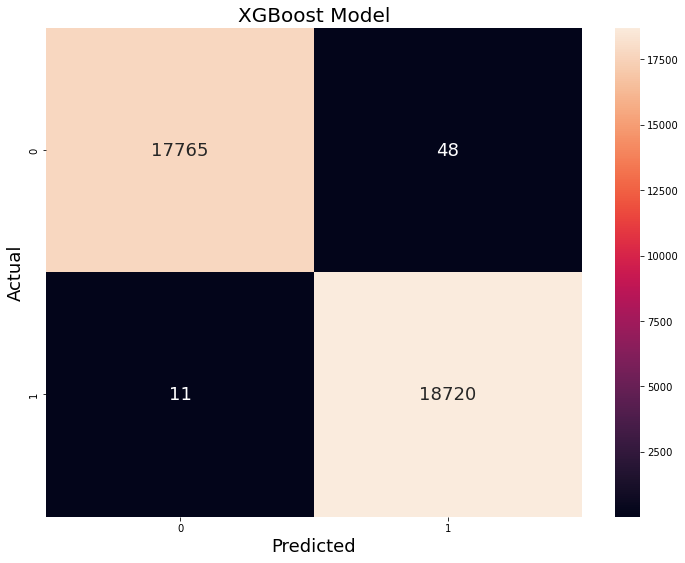

In [129]:
cm = metrics.confusion_matrix(y_test, predict)
cm = pd.DataFrame(cm)

plt.figure(figsize = (12,9))
sns_plot = sns.heatmap(cm, annot=True,fmt='g', annot_kws={"fontsize":18})
plt.ylabel("Actual", fontsize=18)
plt.xlabel("Predicted",fontsize=18)
plt.title("XGBoost Model",fontsize=20)


In [130]:
print(metrics.classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17813
           1       1.00      1.00      1.00     18731

    accuracy                           1.00     36544
   macro avg       1.00      1.00      1.00     36544
weighted avg       1.00      1.00      1.00     36544



In [131]:
tpr = metrics.recall_score(y_test,predict)
tnr = metrics.recall_score(y_test,predict, pos_label=0)
fpr = 1-tnr
fnr = 1-tpr

In [132]:
print('XGBoost')
print('False Positive Rate:',fpr)
print('False Negative Rate:',fnr)

XGBoost
False Positive Rate: 0.00269466120249251
False Negative Rate: 0.0005872617585820361


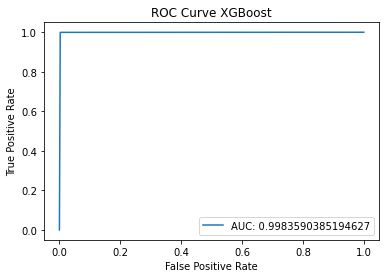

In [133]:
fpr_xgb_roc,tpr_xgb_roc, _ = metrics.roc_curve(y_test,predict)
auc_xgb = metrics.roc_auc_score(y_test, predict)
plt.plot(fpr_xgb_roc,tpr_xgb_roc, label='AUC: '+str(auc_xgb))
plt.title('ROC Curve XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

# Deploy do modelo

O modelo pode ser publicado por meio da criação de um script de scoring para predizer valores usando o modelo em pickle (.pkl). O script pode ser publicado em um endpoint para uso.

# Melhorias

Por mais que o modelo tenha apresentado ótimos resultados, ainda existe a possibilidade de melhorá-lo. O teste de outros modelos em comparação ao XGBoost é válido e altamente recomendado, como o LightGBM, RandomForest, KNN, etc.\
Sobre o processamento dos dados, pode-se testar novas maneiras de realizar o undersampling e/ou oversampling do modelo, já que a aplicação do SMOTEENN duplicou as observações, o que não pode ser aplicado em cenários onde já existem muitas observações. \
Também é válido estudar a possibilidade de utilizar métodos de seleção de variáveis de 
redução de dimensão para tornar os dados mais enxutos e otimizar o modelo.
Além disso, o tempo de execução do código poderia ser melhorado através do uso do 
Hadoop e Spark.\
O uso de recursos automatizados em serviços de nuvem (como o Azure ML e o AWS 
SageMaker) podem ser estudados visando otimizar o processo de criação, avaliação e 
deploy do modelo.\
Também se pode avaliar o uso de modelos de série temporal e deep learning, como o LSTM, Autoencoders e outros métodos de anomaly detection.